# Introduction

This demo is on XGBoost classification following [shap doc here](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Front%20page%20example%20%28XGBoost%29.html), check out the similarities and differences with RandomForestClassifier in `shap_basic_2.ipynb` in the same repo.

In [1]:
import math
import numpy as np
np.set_printoptions(formatter={'float':lambda x:"{:.4f}".format(x)})
import pandas as pd
pd.options.display.float_format = "{:.3f}".format
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='rainbow')
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, 
                              RandomForestClassifier)
import xgboost as xgb
import shap #v0.39.0
shap.initjs()

# Import sample data
df =  sns.load_dataset('titanic')
df['is_male'] = df['sex'].map({'male': 1, 'female': 0}) # Encode
# Keep numerical complete columns
df = df.select_dtypes('number').dropna() 
X = df.drop(columns=['survived'])
y = df['survived']
# Partition data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}\n")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")
display(X_train.head())
# Train a simple model
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

Training features shape: (571, 6)
Training target shape: (571,)

Test features shape: (143, 6)
Test target shape: (143,)


,pclass,age,sibsp,parch,fare,is_male
830,3,15.000,1,0,14.454,0
565,3,24.000,2,0,24.150,1
148,2,36.500,0,2,26.000,1
105,3,28.000,0,0,7.896,1
289,3,22.000,0,0,7.750,0


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

We can see from the results below that
* Just like regression shap_test.data will contain the same number of records as the X_test. 
* However, the dimension of `values` and `base_values` are different.

In [2]:
# get the explainer and create shap values
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test for the first case:\n{shap_test[0]}")

Length of shap_test: 143

Sample shap_test for the first case:
.values =
array([1.7204, -0.0535, 0.1124, 0.1107, -1.0535, 2.9162], dtype=float32)

.base_values =
-0.48516756

.data =
array([1.0000, 15.0000, 0.0000, 1.0000, 211.3375, 0.0000])


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## Base Value

Unlike in RandomForest Clssifier (see another note in the same repo) where both the base_values and expected_value is the probability for both class. The XGBoostRegressor result relate to raw maginal contributions and need to be transformed to probabilities (see below).


In [3]:
print(f"Expected value: {explainer.expected_value:.2f}")
print(f"Average target value (training data): {y_train.mean():.2f}")
print(f"Base value: {shap_test.base_values[0]:.2f}")

Expected value: -0.49
Average target value (training data): 0.41
Base value: -0.49


## Shap Values
Shap values are the marginal contributions for each feature. 

In [4]:
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

,pclass,age,sibsp,parch,fare,is_male
689,1.720,-0.054,0.112,0.111,-1.053,2.916
278,-1.033,1.529,-2.234,-0.289,-2.745,-0.593
506,1.200,0.682,0.219,-0.046,0.090,3.239
9,1.176,-0.831,0.192,-0.149,-0.096,3.047
494,-0.891,-1.525,0.004,-0.038,0.207,-0.865
...,...,...,...,...,...,...
581,1.837,-0.140,0.137,-0.268,2.583,3.229
44,-1.237,0.663,-0.012,-0.194,-0.399,2.293
234,-0.366,-1.392,-0.001,-0.090,-0.311,-1.535
781,2.221,0.178,0.067,-0.173,1.484,2.926


Like in regression before, adding up shap values and the base values shoud give us the predicted value, which is confirmed below. Note that we need to output raw margin by defining `output_margin = True` when making the predictions.

In [5]:
np.isclose(model.predict(X_test, output_margin=True), 
           explainer.expected_value + shap_df.sum(axis=1))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

To transform raw margin to probabilities, we need to employ sigmoid function. The raw_margin is positive when the predicted probability is higher than 0.5, and negative when the predicted probability is lower than 0.5.

In [6]:
y_prob = model.predict_proba(X_test)
y_pred_margin = model.predict(X_test, output_margin = True)
sig_transform = pd.DataFrame({
    'raw_margin': y_pred_margin,
    'predicted_probability': y_prob[:,1]
})
# transform the margin into probability using sigmoid function
from scipy.special import expit
sig_transform['sig_transform'] = expit(sig_transform['raw_margin'])
sig_transform.head()

,raw_margin,predicted_probability,sig_transform
0,3.267,0.963,0.963
1,-5.851,0.003,0.003
2,4.899,0.993,0.993
3,2.854,0.946,0.946
4,-3.593,0.027,0.027


## Shap Built-in Plots

### Global | Feature Importance

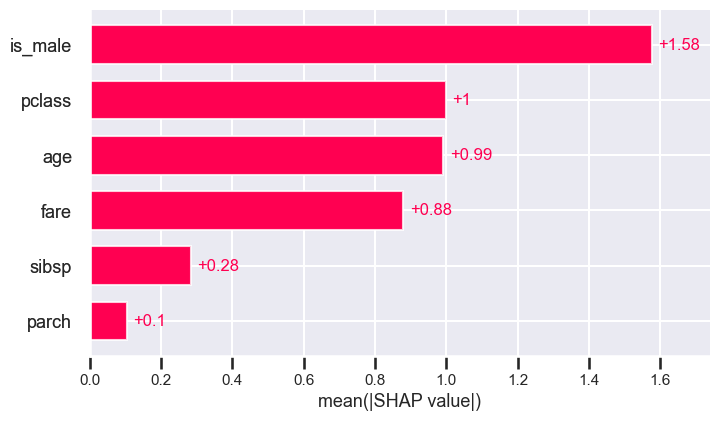

In [7]:
shap.plots.bar(shap_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


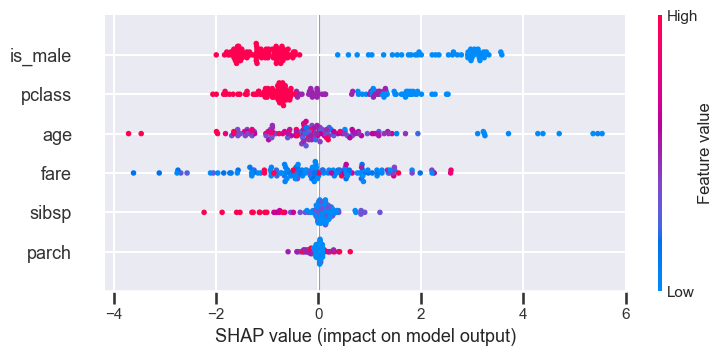

In [8]:
shap.summary_plot(shap_test)

### Local | Waterfall

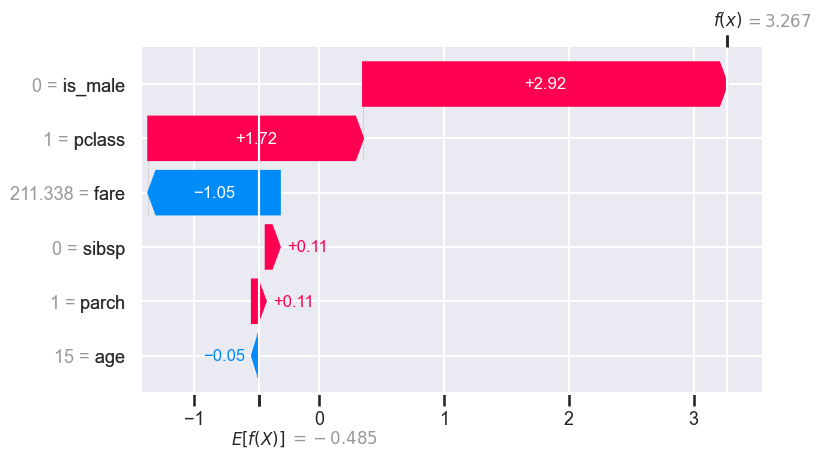

In [9]:
shap.plots.waterfall(shap_test[0])

# Discussions

There you have it, shap explanation for XGBoost classifier expalained. With some sigmoid transformation, we can add up shap values from each individual features to get the final predicted probability.

One question remains, however, why isn't the below True? We remember for RandomForest Classifier, the `explainer.expected_value[1]` equals rate of the positive class in the train data, that is, `y_train.mean()`. 

In [10]:
# question remains, why isn't the below true?
expit(explainer.expected_value) == y_train.mean()

False